In [39]:
import os
import cv2
import glob
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [40]:
# 1. Camera Calibration and Distortion Correction

In [41]:
# to capture the transformation between the 3D world and the 2D points
def calibrate_camera(cal_images, nx, ny):
    objpoints = []  # 3D points
    imgpoints = []  # 2D points

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = cal_images[0]
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

In [42]:
cal_images = glob.glob('camera_cal/calibration*.jpg')
nx, ny = 9, 6
mtx, dist = calibrate_camera(cal_images, nx, ny)

In [43]:
dist

array([[-0.24688572, -0.02372824, -0.00109832,  0.00035104, -0.00260433]])

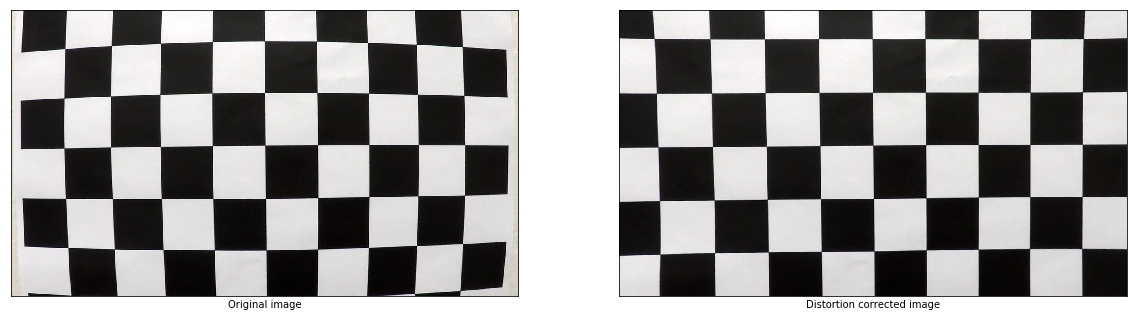

In [44]:
image = mpimage.imread('camera_cal/calibration1.jpg')

undist = cv2.undistort(image, mtx, dist, None, mtx)
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(undist)
plt.xlabel('Distortion corrected image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

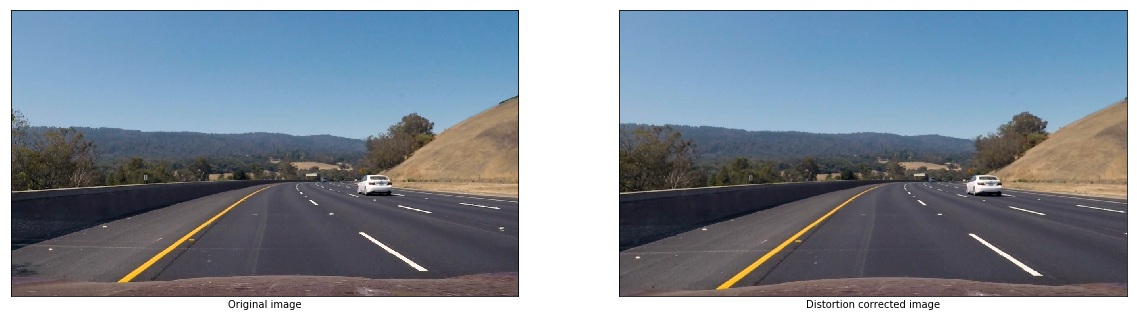

In [45]:
image = mpimage.imread('test_images/test3.jpg')

undist = cv2.undistort(image, mtx, dist, None, mtx)
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(undist)
plt.xlabel('Distortion corrected image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [46]:
# use HLS for color transform

def hls_transform(img, thresh = [90, 255]):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    binary = np.zeros_like(S)
    binary[(S >= thresh[0]) & (S <= thresh[1])] = 1
    
    return binary

def hsv_transform(img, yellow_hsv_low, yellow_hsv_high, white_hsv_low, white_hsv_high):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    yellow_lane = cv2.inRange(hsv,yellow_hsv_low,yellow_hsv_high)
    white_lane = cv2.inRange(hsv,white_hsv_low,white_hsv_high)
    binary = cv2.bitwise_or(yellow_lane,white_lane)
    
    return binary

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobely = np.absolute(sobely)
    abs_sobelx = np.absolute(sobelx)
    
    dir_angle = np.arctan2(abs_sobely, abs_sobelx)
    #print (dir_angle)
    
    binary =  np.zeros_like(dir_angle)
    binary[(dir_angle >= thresh[0]) & (dir_angle <= thresh[1])] = 1

    return binary


def abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(90, 225)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == "y":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary = np.zeros_like(scaled_sobel)
    
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary

    

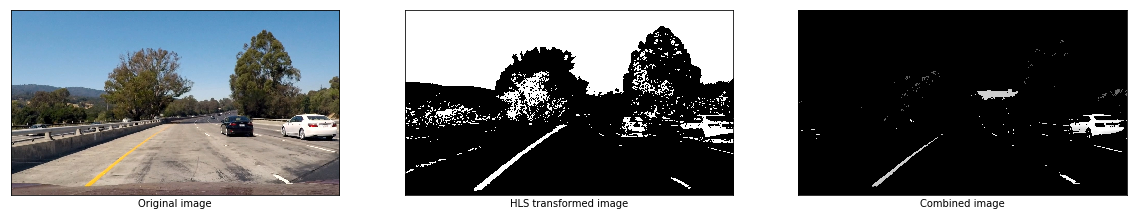

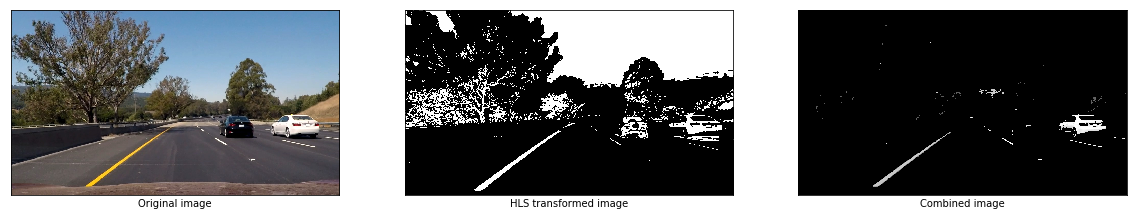

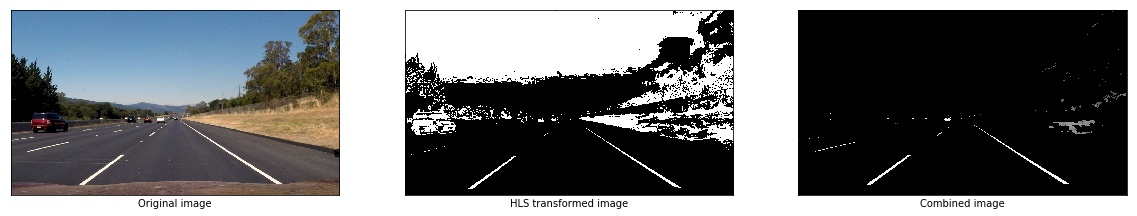

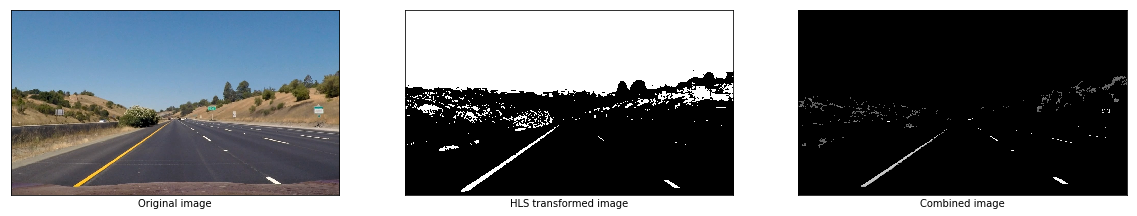

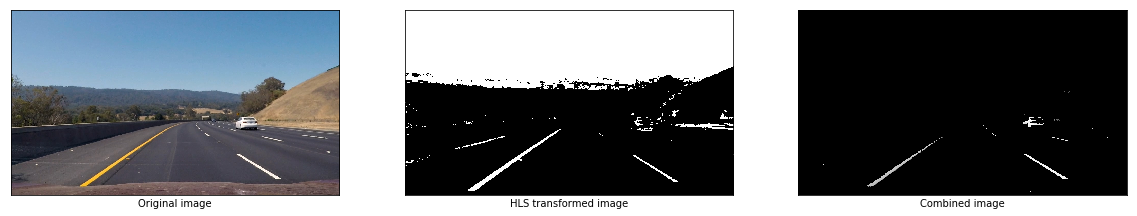

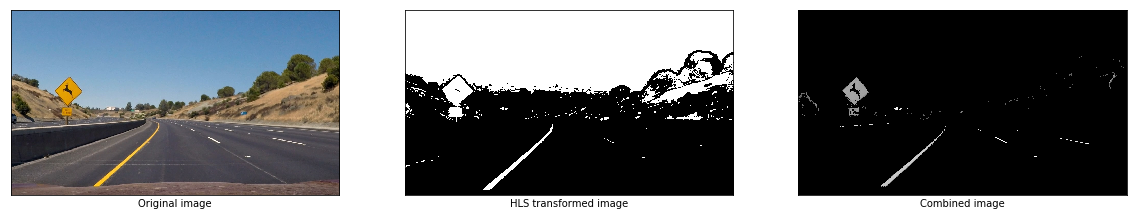

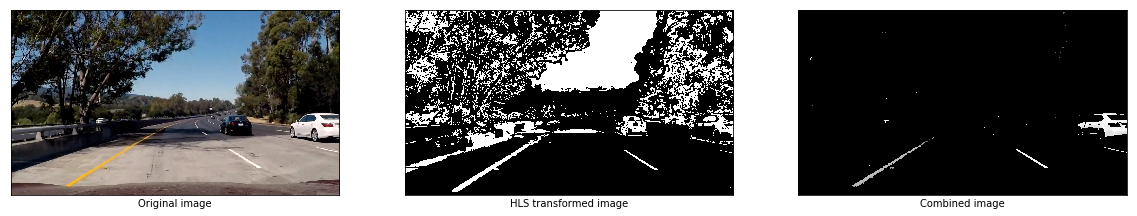

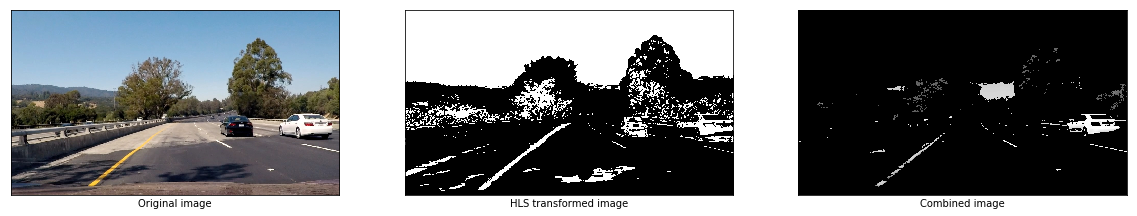

In [47]:
for img in (os.listdir("test_images/")):
    image = mpimage.imread('test_images/' + img)
    # distortion correction
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    #apply HLS transform
    binary_S = hls_transform(undist)
    
    binary_dir = dir_threshold(image)
    
    binary_x = abs_sobel_thresh(image)
    binary_y = abs_sobel_thresh(image, 'y')
    
    
    yellow_hsv_low  = np.array([ 20,100,100])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  0,   0,   220])
    white_hsv_high = np.array([ 255,  40, 255])
    binary_hsv = hsv_transform(image, yellow_hsv_low, yellow_hsv_high, white_hsv_low, white_hsv_high)
    
    #print (binary_hsv)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    combined = cv2.bitwise_and(gray, binary_hsv)
    #combined = np.zeros_like(binary_dir)
    #combined[((binary_S == 1) & (binary_hsv == 255)) ] = 1
    

    plt.figure(figsize=(20,10))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.xlabel('Original image')
    plt.xticks([], [])
    plt.yticks([], [])

    plt.subplot(1, 3, 2)
    plt.imshow(binary_S, cmap='gray')
    plt.xlabel('HLS transformed image')
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.subplot(1, 3, 3)
    plt.imshow(combined, cmap='gray')
    plt.xlabel('Combined image')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

In [48]:
# perspective transform
def warp(img, src, des):
    img_size = (img.shape[1], img.shape[0])
    
    M = cv2.getPerspectiveTransform(src, des)
    
    Minv = cv2.getPerspectiveTransform(des, src)
    
    return M, Minv


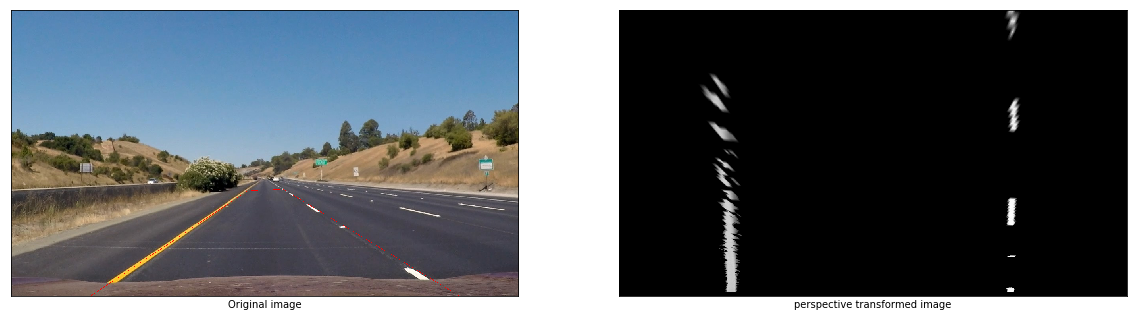

In [49]:
src = np.float32(
    [(200, 720),  # bot left
     (595, 455),  # top left  
     (685, 450),  # top right
     (1130, 720)  # bot right
    ])

des = np.float32(
    [(280, 720), # bot left
    (280, 0), # top left
    (1000, 0), # top right
    (1000, 720), # bot right
    ])

image = mpimage.imread('test_images/' + "straight_lines1.jpg")
img_size = (image.shape[1], image.shape[0])
# distortion correction
undist = cv2.undistort(image, mtx, dist, None, mtx)
#apply HLS transform
binary_S = hls_transform(undist)

binary_dir = dir_threshold(image)

binary_x = abs_sobel_thresh(image)
binary_y = abs_sobel_thresh(image, 'y')


    
yellow_hsv_low  = np.array([ 20,100,100])
yellow_hsv_high = np.array([ 50, 255, 255])

white_hsv_low  = np.array([  0,   0,   220])
white_hsv_high = np.array([ 255,  40, 255])

binary_hsv = hsv_transform(image, yellow_hsv_low, yellow_hsv_high, white_hsv_low, white_hsv_high)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
combined = cv2.bitwise_and(gray, binary_hsv)
#combined = np.zeros_like(binary_dir)
#combined[((binary_S == 1) & (binary_hsv == 255)) ] = 1

M, Minv = warp(combined, src, des)

binary_warped = cv2.warpPerspective(combined, M, img_size)

pts = np.array([[200, 720],
                [595, 455],
                [685, 450],
                [1130, 720]], np.int32)
pts = pts.reshape((-1,1,2))

cv2.polylines(image,[pts],True,(255,0,0))

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(binary_warped, cmap='gray')
plt.xlabel('perspective transformed image')
plt.xticks([], [])
plt.yticks([], [])

plt.show()

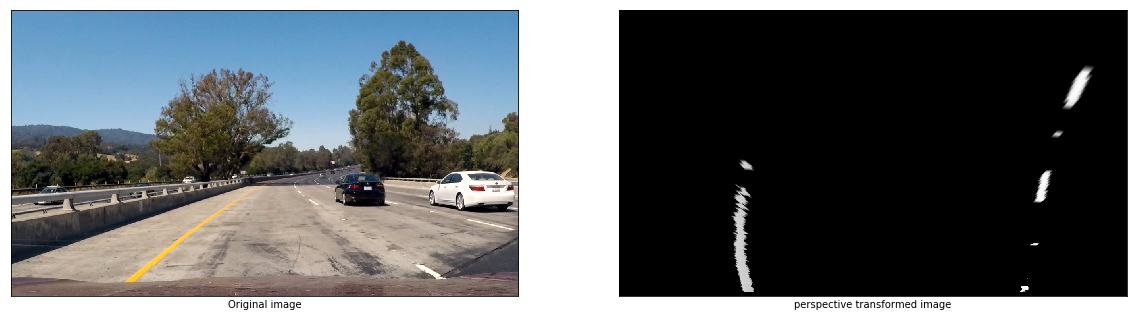

In [50]:
image = mpimage.imread('test_images/' + "test1.jpg")
img_size = (image.shape[1], image.shape[0])
# distortion correction
undist = cv2.undistort(image, mtx, dist, None, mtx)
#apply HLS transform
binary_S = hls_transform(undist)

binary_dir = dir_threshold(image)

binary_x = abs_sobel_thresh(image)
binary_y = abs_sobel_thresh(image, 'y')

binary_hsv = hsv_transform(image, yellow_hsv_low, yellow_hsv_high, white_hsv_low, white_hsv_high)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
combined = cv2.bitwise_and(gray, binary_hsv)

#combined = np.zeros_like(binary_dir)
#combined[((binary_S == 1) & (binary_hsv == 255)) ] = 1

binary_warped = cv2.warpPerspective(combined, M, img_size)


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(binary_warped, cmap='gray')
plt.xlabel('perspective transformed image')
plt.xticks([], [])
plt.yticks([], [])

plt.show()

In [51]:
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# locate the lane lines and fit a polynormal
def loc_draw_line(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) # "//" return interger, "/" return floatin python 3
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if (len(left_lane_inds)):
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = []
    if (len(right_lane_inds)):    
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = []
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

In [52]:
nonzeroy[left_lane_inds]

array([640, 640, 640, ..., 319, 319, 319])

(720, 1280)


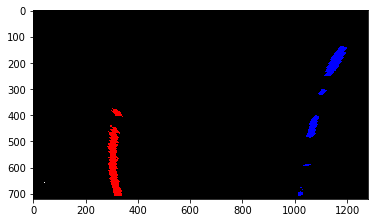

In [53]:
left_fit, right_fit, left_lane_inds, right_lane_inds = loc_draw_line(binary_warped)
print (binary_warped.shape)
binary_warped = binary_warped.astype('uint8') # to show the red and blue colors correctly

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)



(720, 0)

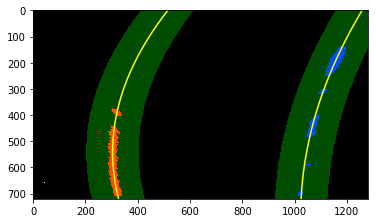

In [54]:
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [63]:
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
def add_polygon(binary_warped, left_fit, right_fit):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    between_line_pts = np.hstack((left_line, right_line))

    zero_warp = np.zeros_like(binary_warped)
    out_img = np.dstack((zero_warp, zero_warp, zero_warp))
    #window_img = np.zeros_like(out_img)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([between_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    return out_img

In [64]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def find_lines_rest(left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    new_left_fit = np.polyfit(lefty, leftx, 2)
    new_right_fit = np.polyfit(righty, rightx, 2)
    
    return new_left_fit, new_right_fit, left_lane_inds, right_lane_inds

In [65]:
def cal_conversions(binary_warped, left_lane_inds, right_lane_inds):
    binary_warped = binary_warped.astype('uint8') # to show the red and blue colors correctly
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    y_eval = 720
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad
    # Example values: 632.1 m    626.2 m

def cal_dist_to_center(binary_warped, left_fit, right_fit):
    binary_warped = binary_warped.astype('uint8') # to show the red and blue colors correctly
    nonzero = binary_warped.nonzero()
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    middle = (left_fitx[-1] + right_fitx[-1])//2
    veh_pos = binary_warped.shape[1]/2
    offset = (veh_pos - middle)*xm_per_pix
    return offset

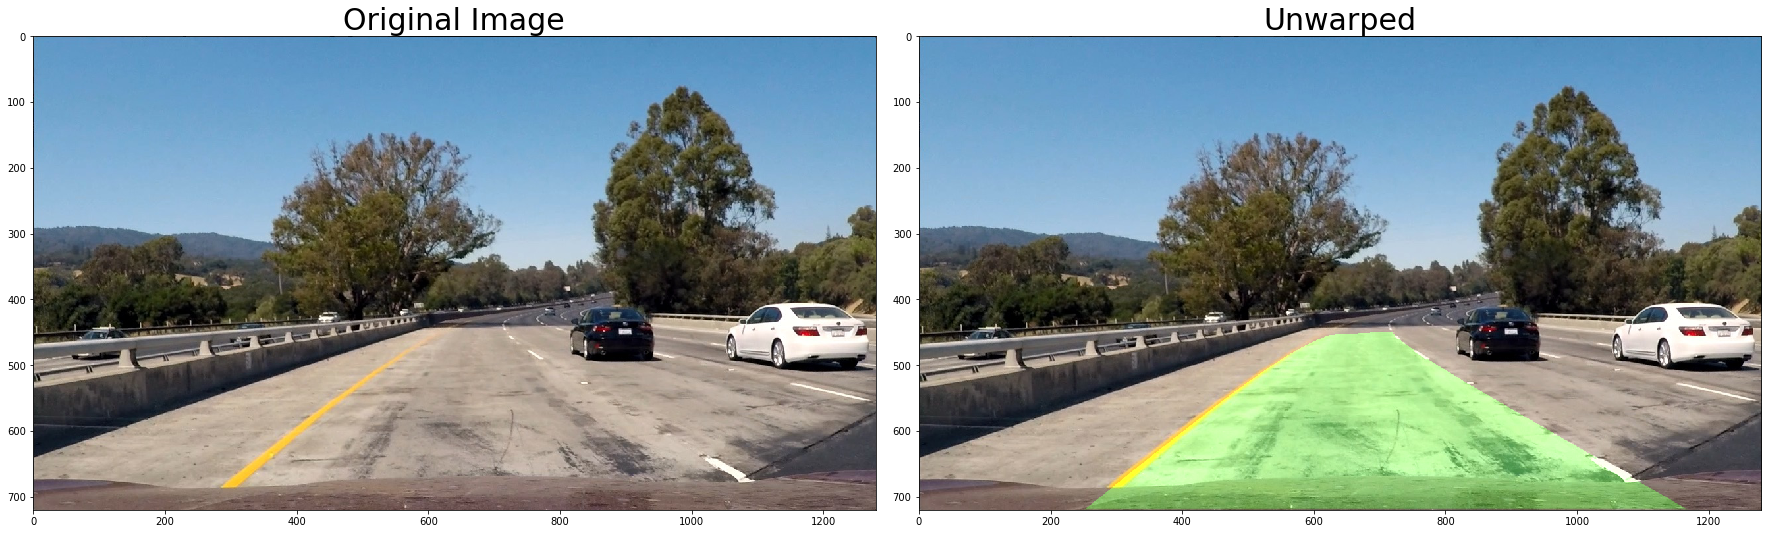

In [66]:
res = add_polygon(binary_warped, left_fit, right_fit)
unwarped = cv2.warpPerspective(res, Minv, img_size)
result = cv2.addWeighted(image, 1, unwarped, 0.3, 0)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(result)
ax2.set_title('Unwarped', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [67]:
def print_info(image, left, right, dist_center):
    img = np.copy(image)
    # Add message to image
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img,'Left radius of curvature  = %.2f m'%(left),(60,60), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img,'Right radius of curvature = %.2f m'%(right),(60,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img,'Vehicle position : %.2f m %s from center'%(abs(dist_center), 'left' if dist_center < 0 else 'right'),(60,140), font, 1,(255,255,255),2,cv2.LINE_AA)
    return img

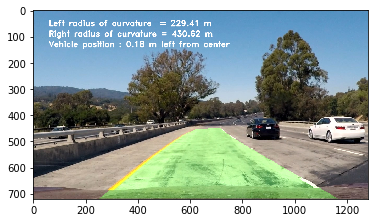

In [68]:
left_curverad, right_curverad = cal_conversions(binary_warped, left_lane_inds, right_lane_inds)
dist_center = cal_dist_to_center(binary_warped, left_fit, right_fit)
plt.imshow(print_info(result, left_curverad, right_curverad, dist_center))

In [73]:

def pipeline(image):
    # distortion
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    #apply HLS transform
    binary_S = hls_transform(undist)
    # direction threshold
    binary_dir = dir_threshold(image)
    # sobel threshold
    binary_x = abs_sobel_thresh(image)
    binary_y = abs_sobel_thresh(image, 'y')
    # hsv threshold
    binary_hsv = hsv_transform(image, yellow_hsv_low, yellow_hsv_high, white_hsv_low, white_hsv_high)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    combined = cv2.bitwise_and(gray, binary_hsv)
    # combined
    #combined = np.zeros_like(binary_dir)
    #combined[((binary_S == 1) & (binary_hsv == 255)) ] = 1
    # perspective transform
    binary_warped = cv2.warpPerspective(combined, M, img_size)
    binary_warped = binary_warped.astype('uint8')
    # find and draw the line
    left_fit, right_fit, left_lane_inds, right_lane_inds = loc_draw_line(binary_warped)
    
    left_curverad = 0
    right_curverad = 0
    dist_center = 0
    
    if (len(left_fit) > 0)and(len(right_fit) > 0):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        res = add_polygon(binary_warped, left_fit, right_fit)
        unwarped = cv2.warpPerspective(res, Minv, img_size)
        
        result = cv2.addWeighted(image, 1, unwarped, 0.3, 0)
        left_curverad, right_curverad = cal_conversions(binary_warped, left_lane_inds, right_lane_inds)
        dist_center = cal_dist_to_center(binary_warped, left_fit, right_fit)
        result = print_info(result, left_curverad, right_curverad, dist_center)
    else:
        result = print_info(image, left_curverad, right_curverad, dist_center)
    return result


In [74]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'project_out_new.mp4'

clip_project = VideoFileClip("project_video.mp4")
project_clip = clip_project.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_out_new.mp4
[MoviePy] Writing video project_out_new.mp4


100%|█████████▉| 1260/1261 [05:27<00:00,  3.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_out_new.mp4 

CPU times: user 6min 35s, sys: 3.08 s, total: 6min 38s
Wall time: 5min 28s


In [158]:
result = cv2.addWeighted(image, 1, unwarped, 0.3, 0)

In [163]:
image

array([[[254, 233, 216],
        [245, 238, 232],
        [196, 205, 212],
        ..., 
        [ 16,  35,  52],
        [ 20,  37,  53],
        [ 32,  48,  63]],

       [[245, 238, 232],
        [188, 193, 197],
        [137, 158, 175],
        ..., 
        [ 74, 108, 135],
        [ 47,  77, 103],
        [  4,  34,  60]],

       [[193, 202, 209],
        [134, 157, 173],
        [115, 154, 183],
        ..., 
        [ 95, 144, 184],
        [ 89, 137, 177],
        [ 52,  97, 136]],

       ..., 
       [[141, 131, 129],
        [132, 121, 119],
        [114, 100,  97],
        ..., 
        [ 99,  80,  74],
        [ 99,  80,  74],
        [113,  94,  88]],

       [[164, 154, 152],
        [133, 122, 120],
        [120, 106, 103],
        ..., 
        [107,  88,  82],
        [109,  90,  84],
        [111,  92,  86]],

       [[189, 179, 177],
        [135, 125, 123],
        [128, 117, 113],
        ..., 
        [ 97,  78,  72],
        [ 95,  76,  70],
        [ 73,  54,

In [164]:
unwarped

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)